In [1]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rc('font', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

train_path = 'underexpose_train/'
test_path = 'underexpose_test/'
now_phase = 9

##### train
train_user_df = pd.read_csv(train_path + 'underexpose_user_feat.csv',
                            names=['user_id', 'user_age_level', 'user_gender', 'user_city_level'])
train_item_df = pd.read_csv(train_path + 'underexpose_item_feat.csv')
train_click_0_df = pd.read_csv(train_path + 'underexpose_train_click-0.csv', 
                                names=['user_id', 'item_id', 'time'])

##### test
test_qtime_0_df = pd.read_csv(test_path + 'underexpose_test_qtime-0.csv', 
                                names=['user_id', 'query_time'])
test_click_0_df = pd.read_csv(test_path + 'underexpose_test_click-0.csv', 
                                names=['user_id', 'item_id', 'time'])

user_feat_df = pd.read_csv(train_path + 'underexpose_user_feat.csv', names=['user_id', 'age', 'gender', 'city_level'])
item_feat_df = pd.read_csv(train_path + 'underexpose_item_feat.csv', header=None)
item_feat_df.columns = ['item_id'] + ['txt_vec'+str(i) for i in range(128)] + ['img_vec'+str(i) for i in range(128)]
item_feat_df['txt_vec0'] = item_feat_df['txt_vec0'].apply(lambda x:float(x[1:]))
item_feat_df['txt_vec127'] = item_feat_df['txt_vec127'].apply(lambda x:float(x[:-1]))
item_feat_df['img_vec0'] = item_feat_df['img_vec0'].apply(lambda x:float(x[1:]))
item_feat_df['img_vec127'] = item_feat_df['img_vec127'].apply(lambda x:float(x[:-1]))

train_click = []
test_click = []
test_qtime = []
train_click_df = pd.DataFrame()
test_click_df = pd.DataFrame()
test_qtime_df = pd.DataFrame()
for c in range(now_phase + 1):
    train_click.append(pd.read_csv(train_path + '/underexpose_train_click-{}.csv'.format(c),
                                  header=None, names=['user_id', 'item_id', 'time']))
    test_click.append(pd.read_csv(test_path + '/underexpose_test_click-{}.csv'.format(c),
                                 header=None, names=['user_id', 'item_id', 'time']))
    test_qtime.append(pd.read_csv(test_path + '/underexpose_test_qtime-{}.csv'.format(c),
                                 header=None, names=['user_id', 'time']))
    train_click_df = train_click_df.append(train_click[c])
    test_click_df = test_click_df.append(test_click[c])
    test_qtime_df = test_qtime_df.append(test_qtime[c])

In [13]:
df = pd.DataFrame()
qtime_df = pd.DataFrame()
for i in range(7, 10):
    df = df.append(train_click[i].append(test_click[i])).drop_duplicates().sort_values(by='time')
    qtime_df = qtime_df.append(test_qtime[i])
qtime_df.rename(columns={'time': 'qtime'}, inplace=True)
join_df = pd.merge(df, qtime_df, how='left', on='user_id')

join_df.fillna(1.0, inplace=True)
aa = join_df.query("time <= qtime")


,user_id,item_id,time,qtime
0,34256,17063,0.984121,1.000000
1,8218,25834,0.984121,1.000000
2,7609,72882,0.984121,0.984312
3,20376,4755,0.984121,1.000000
4,15838,86909,0.984121,0.984441
...,...,...,...,...
511713,4427,8724,0.984448,1.000000
511714,30210,79176,0.984448,1.000000
511715,7240,11877,0.984448,1.000000
511716,3086,30758,0.984448,1.000000


25198 25198


In [17]:
import pickle
item2idx = item_feat_df['item_id'].unique()
item_feat_set = set(item_feat_df['item_id'].unique())
item_feat_dict = {}
for _, row in tqdm(item_feat_df.iterrows(), desc='build item feat'):
    arr = np.zeros(shape=(128))
    for i in range(128):
        arr[i] = row[f"txt_vec{i}"]
    item_feat_dict[int(row['item_id'])] = arr

pickle.dump(item_feat_dict, open('underexpose_train/item_feat.pkl', 'wb'))

In [18]:
item2idx = item_feat_df['item_id'].unique()
item_feat_set = set(item_feat_df['item_id'].unique())
item_feat_dict = {}
for _, row in tqdm(item_feat_df.iterrows(), desc='build item feat'):
    arr = np.zeros(shape=(128))
    for i in range(128):
        arr[i] = row[f"img_vec{i}"]
    item_feat_dict[int(row['item_id'])] = arr

pickle.dump(item_feat_dict, open('underexpose_train/item_img_feat.pkl', 'wb'))

In [2]:
feat_items = set(item_feat_df['item_id'])
click_items = set(train_click_df.append(test_click_df)['item_id'])
len(click_items - feat_items)

8804

In [3]:
feat_users = set(user_feat_df['user_id'])
click_users = []
for phase in range(now_phase + 1):
    click_users.append(set(train_click[phase].append(test_click[phase])['user_id']))

display([len(users) for users in click_users])
display([len(users - feat_users) for users in click_users])

[18505, 18672, 18398, 18821, 18618, 19459, 20396, 19801, 19883, 20047]

[14301, 14431, 14156, 14495, 14308, 15023, 15820, 15186, 15145, 14759]

In [ ]:
train_click_user_feat_df = pd.merge(train_click[0], user_feat_df, how='left', on='user_id')
train_click_user_feat_df.to_csv('join.csv', index=False)
display(len(train_click_user_feat_df['user_id'].unique()))
#count_df = train_click[0].groupby(['user_id', 'item_id'])['time'].transform('count')
#a = count_df.to_numpy()
#display((a == 1).all())                          
# display(train_click_df[train_click_df.duplicated(keep='last')])
# display(test_click[0]['item_id'].value_counts().to_dict())
# display(test_click[0].groupby('user_id')['item_id'].agg(set).reset_index().set_index('user_id')['item_id'].to_dict())

# display(t0_df)
# display(t0_df['item_id'].mean())
# display(t0_df['item_id'].std())
# display(t0_df['item_id'].min())
# display(t0_df['item_id'].quantile(.25))
# display(t0_df['item_id'].quantile(.50))
# display(t0_df['item_id'].quantile(.75))
# display(t0_df['item_id'].max())
# display(test_click[0].query("user_id == 11").sort_values(['time']))
# display(test_qtime[0].query("user_id == 11"))
# set(test_click[3]['user_id'].unique()) == set(test_qtime[3]['user_id'].unique())
a = user_feat_df['user_id'].agg(set)
b = train_click_df['user_id'].agg(set)
c = test_click[0]['user_id'].agg(set)
display(len(b - a))

# ia = item_feat_df['item_id'].agg(set)
# ib = train_click_df['item_id'].agg(set)
# ic = test_click[0]['item_id'].agg(set)
# display(len(ib - ia))
# items = (train_click_df.append(test_click_df))['item_id'].unique()
certain_user_df = train_click_df.drop_duplicates().query("user_id == 123").sort_values(['time']).reset_index()
#user_time_df = train_click_df.drop_duplicates().sort_values('time').groupby('user_id').agg(list).reset_index()
#plt.plot(certain_user_df['time'])
dd = train_click[0]['time'].to_numpy()
display(train_click_df.append(test_click_df)['time'].max())
display(train_click_df.append(test_click_df)['time'].min())
display(train_click_df.append(test_click_df)['time'].mean())
plt.scatter(train_click[0]['time'][:20000] * 1000000, (train_click[0]['user_id'][:20000]))
plt.show()

### 點擊次數統計

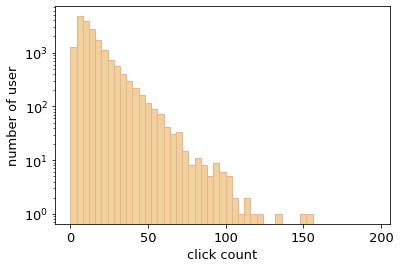

In [7]:
whole_click_df = train_click[0].append(test_click[0]).drop_duplicates()
user_click_cnt_df = whole_click_df['user_id'].value_counts().rename_axis('user_id').reset_index(name='count')
plt.xlabel('click count')
plt.ylabel('number of user')
plt.hist(user_click_cnt_df['count'], [x for x in range(0, 200, 4)], edgecolor='#EFB28C', color='#EED19C', log=True)
plt.show()

### 各個phase time分布

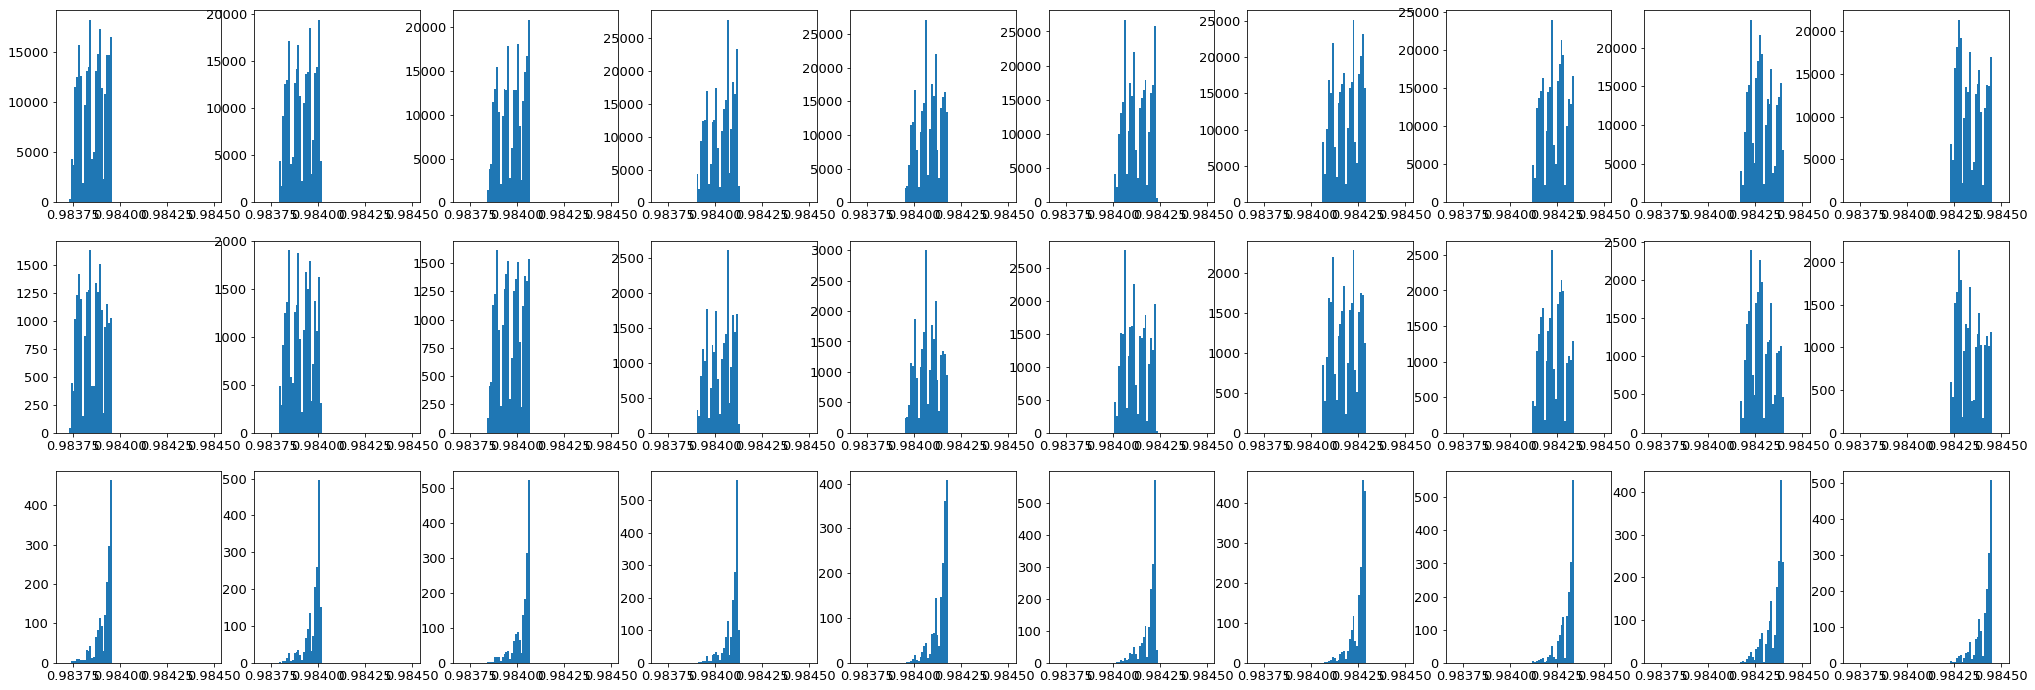

In [8]:
fig = plt.figure(figsize=(35, 12))

for i, x in enumerate(train_click):
    plt.subplot(3, now_phase + 1, i + 1)
    plt.hist(x['time'], np.arange(0.9837, 0.9845, 0.00001))

for i, x in enumerate(test_click):
    plt.subplot(3, now_phase + 1, i + 1 + now_phase + 1)
    plt.hist(x['time'], np.arange(0.9837, 0.9845, 0.00001))

for i, x in enumerate(test_qtime):
    plt.subplot(3, now_phase + 1, i + 1 + 2*(now_phase + 1))
    plt.hist(x['time'], np.arange(0.9837, 0.9845, 0.00001))
    
plt.show()

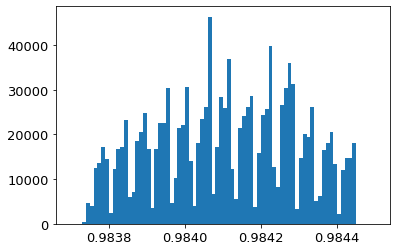

In [9]:
whole_df = train_click_df.append(test_click_df).drop_duplicates()
plt.hist(whole_df['time'], np.arange(0.9837, 0.9845, 0.00001))
plt.show()

[16842, 16946, 16708, 17146, 16910, 17661, 18575]

[40772, 41403, 41027, 42811, 42839, 45628, 48662]

[3276, 2860, 2429, 2461, 3041, 3271, 3626]

[1663, 1726, 1690, 1675, 1708, 1798, 1821]

[15670, 17295, 16314, 16830, 18048, 19194, 20001]

[1561, 1464, 1233, 1247, 1611, 1565, 1820]

(241784, 3)

(242132, 3)

(130986, 3)

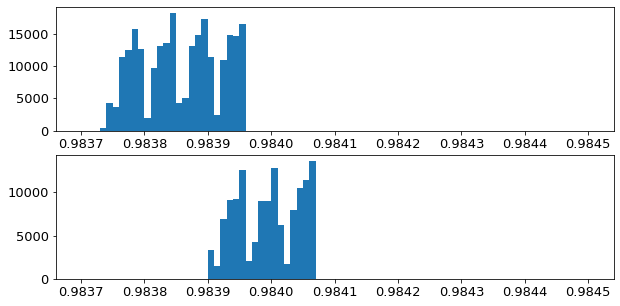

In [62]:
train_user_cnt = []
train_item_cnt = []
train_item_without_feat_cnt = []
test_user_cnt = []
test_item_cnt = []
test_item_without_feat_cnt = []
for df in train_click:
    train_user_cnt.append(len(df['user_id'].unique()))
    train_item_cnt.append(len(df['item_id'].unique()))
    
    train_item_without_feat_cnt.append(len(df[~df.item_id.isin(item_feat_df.item_id)]['item_id'].unique()))
for df in test_click:
    test_user_cnt.append(len(df['user_id'].unique()))
    test_item_cnt.append(len(df['item_id'].unique()))
    test_item_without_feat_cnt.append(len(df[~df.item_id.isin(item_feat_df.item_id)]['item_id'].unique()))
display(train_user_cnt, train_item_cnt, train_item_without_feat_cnt)
display(test_user_cnt, test_item_cnt, test_item_without_feat_cnt)
display(train_click[0].shape, train_click[1].shape)

join_df = pd.merge(train_click[2], train_click[3], how='inner')
display(join_df.shape)
fig = plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.hist(train_click[0]['time'], np.arange(0.9837, 0.9845, 0.00001))
plt.subplot(2, 1, 2)
plt.hist(join_df['time'], np.arange(0.9837, 0.9845, 0.00001))
plt.show()

In [ ]:
for i in range(now_phase + 1):
    sort_df = test_click[i].sort_values('time')
    sort_df = sort_df[sort_df.duplicated(subset=['user_id'], keep=False)]
    user_cnt = sort_df['user_id'].unique().shape[0]
    fake_test_qtime_with_answer_df = sort_df.groupby('user_id').tail(1)
    assert user_cnt == fake_test_qtime_with_answer_df['user_id'].unique().shape[0]

    fake_test_qtime_with_answer_df.to_csv(f'./fake_test/underexpose_test_qtime_with_answer-{i}.csv', index=False, header=False)

    fake_test_click_df = sort_df.drop(fake_test_qtime_with_answer_df.index)
    fake_test_click_df.to_csv(f'./fake_test/underexpose_test_click-{i}.csv', index=False, header=False)

    fake_test_qtime_df = fake_test_qtime_with_answer_df.drop(columns=['time'])
    fake_test_qtime_df.to_csv(f'./fake_test/underexpose_test_qtime-{i}.csv', index=False, header=False)

In [ ]:
train_item_df[:5]
display(set(user_feat_df['user'].unique()) == set(train_click_df['user'].unique()))

In [ ]:
train_click_0_df[:5]

In [ ]:
test_qtime_0_df[:5]

In [ ]:
test_click_0_df[:5]

In [ ]:
train_item_df.columns = ['item_id'] + ['txt_vec'+str(i) for i in range(128)] + ['img_vec'+str(i) for i in range(128)]
train_item_df['txt_vec0'] = train_item_df['txt_vec0'].apply(lambda x:float(x[1:]))
train_item_df['txt_vec127'] = train_item_df['txt_vec127'].apply(lambda x:float(x[:-1]))
train_item_df['img_vec0'] = train_item_df['img_vec0'].apply(lambda x:float(x[1:]))
train_item_df['img_vec127'] = train_item_df['img_vec127'].apply(lambda x:float(x[:-1]))

# rank
train_click_0_df['rank'] = train_click_0_df.groupby(['user_id'])['time'].rank(ascending=False).astype(int)
test_click_0_df['rank'] = test_click_0_df.groupby(['user_id'])['time'].rank(ascending=False).astype(int)

# click cnts
train_click_0_df['click_cnts'] = train_click_0_df.groupby(['user_id'])['time'].transform('count')
test_click_0_df['click_cnts'] = test_click_0_df.groupby(['user_id'])['time'].transform('count')

print(test_click_0_df.groupby(['user_id'])['time'].count())

In [ ]:
print(train_item_df.describe())
train_item_df[:5]

In [ ]:
train_click_0_df[:10]

In [ ]:
plt.figure()
plt.figure(figsize=(16, 10))
i = 1
for col in ['user_id', 'user_age_level', 'user_gender', 'user_city_level']:
    plt.subplot(2, 2, i)
    i += 1
    v = train_user_df[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()